# Neural Networks - recitation 


```In this short excersice, you will experience with implementing neural network for binary classification task, and check it on a real dataset.
It may give you a basic understanding about the model and it's limits, and above all, about how it works.```


```So lets start by itroduction to some notions, that will help us use "gradient descent" methods to train networks.```

```~Gild Royz```

## Chain rule

``for a given functions, h,f,g such that:``

$$h(x) = f(g(x))$$

``we know that:``

$$\frac{dh}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$$

```For example: ```

$f(x) = x^2$

$g(x) = 2x + 5$

$h(x) = f(g(x))$

$$\frac{dh}{dx} = 2(2x + 5) \cdot 2 = 8x + 20$$

## Functions as computational graphs

```Every function can be writen as a computational acyclic graph, where the nodes are the variables, and the egdes are the actions. Example:```

$$f(x) = x^2 + 5x^3$$

```Its computation graph is:```

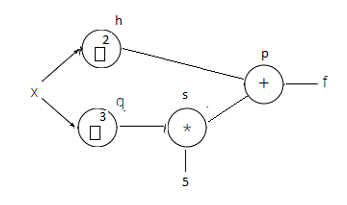

```Ok cool. how is it helping us?
Lets try to calculate ``` $\frac{\partial}{\partial x}f$ ``` and see what we get:```

($\frac{\partial}{\partial x}f$ stands for deriving f according to x)

$$\frac{\partial}{\partial x}f = 2x + 15x^2$$

``But because that f is composed of several functions, we can write it as follow:``

$$f(x) = f(p(h(x), s(q(x))))$$

``if we will derive the function according to the chan rule, we will get:``

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial p} \cdot \frac{\partial p}{\partial x} = \frac{\partial f}{\partial p} \cdot (\frac{\partial p}{\partial h} \cdot  \frac{\partial h}{\partial x} + \frac{\partial p}{\partial s} \cdot  \frac{\partial s}{\partial x}) = \frac{\partial f}{\partial p} \cdot (\frac{\partial p}{\partial h} \cdot  \frac{\partial h}{\partial x} + \frac{\partial p}{\partial s} \cdot  \frac{\partial s}{\partial q} \cdot \frac{\partial q}{\partial x}) = 1 \cdot (1 \cdot 2x + 1 \cdot 5 \cdot 3x^2) = 2x + 15x^2$$

``We can conclude from here, that the derivation of a node u, according to earlier node v, is the sum of derivations of all paths between v -> u.``

In [ ]:
from sklearn import datasets
import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score, auc, roc_curve

```We will look at the "breast cancer" dataset, and try to build a neural network that fits it.```

In [ ]:
X = datasets.load_breast_cancer()['data']
Y = datasets.load_breast_cancer()['target']

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size =0.8)

```Lets Normalize the data to have "mean 0" and "standard deviation 1", in order to help the network deal with it.```

In [ ]:
scaler = StandardScaler()
new_train_X = scaler.fit_transform(train_X)
new_test_X = scaler.transform(test_X)

In [ ]:
# from keras import Model
# from keras.layers import Dense, Input
# from keras.optimizers import SGD
# from keras.losses import binary_crossentropy

# inp = Input((30,))
# #hidden = Dense(20, activation='relu')(inp)
# hidden = Dense(10, activation='relu')(inp)
# out = Dense(1, activation='sigmoid')(hidden)

# model = Model(inp, out)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(new_train_X, train_Y, batch_size=10, epochs=70, validation_data=(new_test_X, test_Y))

### Relu activation

$$relu(x) = \begin{cases} x, \hspace{1cm} x \geq 0 \\ 0, \hspace{1cm} otherwize \end{cases}$$

$$\frac{d}{dx} relu = \begin{cases} 1, \hspace{1cm} x \geq 0 \\ 0, \hspace{1cm} otherwize \end{cases}$$

In [ ]:
def relu(x):
    
    return np.maximum(x, 0)

def relu_derive(x):
    return np.maximum(x >= 0, 0)

### Sigmoid activation

$$sigmoid(x) = \frac{1}{1 + e^{-x}}$$

$$\frac{d}{dx} sigmoid = sigmoid(x) \cdot (1 - sigmoid(x))$$

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derive(x):
    s = sigmoid(x)
    return s * (1 - s)

### Cross entropy

$y \in {0,1}$ - true label,  $\hspace{1cm}$  $\hat{y} \in [0,1]$ - predicted label

$$cross-entropy(y,\hat{y}) = - y * log(\hat{y}) - (1 - y) * log(1 - \hat{y})$$

```When y is 0, we get punish if y_hat is bigger then 0.```

```When when y is 1 we get punish if y_hat is smaller then 1.```

and the derivative according to $\hat{y}$ is:

$$\frac{d}{d \hat{y}}cross-entropy(y,\hat{y}) = - \frac{y}{\hat{y}} + \frac{(1 - y)}{1 - \hat{y}}$$

In [ ]:
def binary_cross_entropy(y, y_hat, epsilon=1e-10):
    """
    y:       true label.
    y_hat:   predicted_label.
    epsilon: small addition for not dividing by 0.
    """
    
    return - y * np.log(y_hat + epsilon) - (1 - y) * np.log(1 - y_hat + epsilon)

def binary_cross_entropy_derive(y, y_hat, epsilon=1e-10):
    
    return - y / (y_hat + epsilon) + (1 - y) / (1 - y_hat + epsilon)

## Architecture

```We will do a 2-layer fully connected NN with the following details:```

- ```First layer  - 10 neurons with "relu" activation.```
- ```Second layer - 1 neurons with "sigmoid" activation.```
- ```Loss         - "binary crossentropy"```

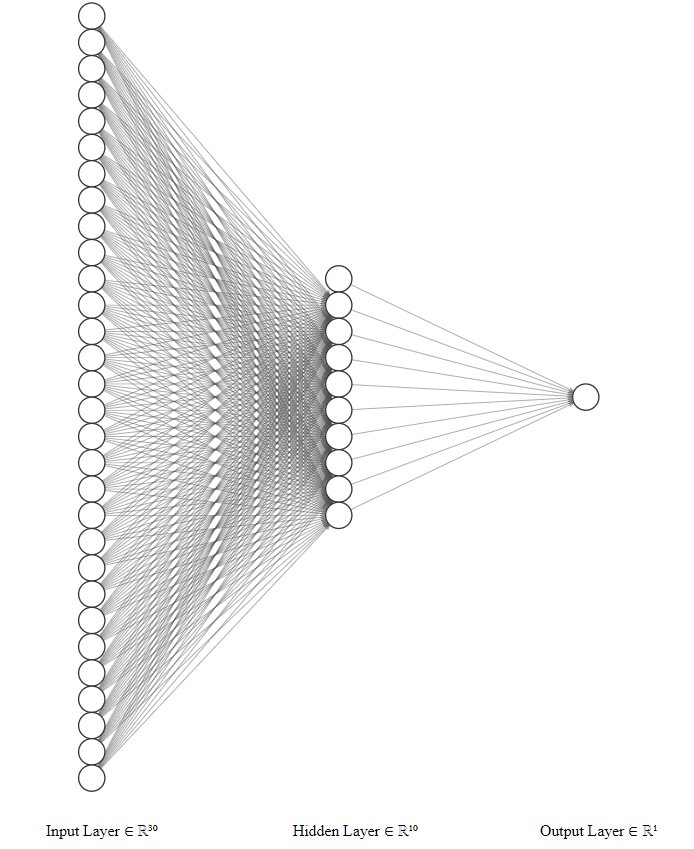

In [ ]:
def predict_full(X, w_1, u1, w_2, u2):
    """
    X  : the data with shape (30 x N)
    
    w_1: first layer weights with shape (10 x 30)
    u_1: first layer bias with shape (10 x 1)
    
    w_2: second layer weights with shape (1 x 10)
    u_2: second layer bias with shape (1 x 1)
    """
    
    a = np.matmul(w_1, X)
    a_z = relu(a + u1)
    
    b = np.matmul(w_2, a_z)
    b_z = sigmoid(b + u2)
    
    return a, a_z, b, b_z

def predict(X, w_1, u1, w_2, u2):
    
    return predict_full(X, w_1, u1, w_2, u2)[-1]

In [ ]:
def plot_training_process(train_losses, train_accs, val_losses=None, val_accs=None):
    
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.set_figheight(5)
    
    ax[0].set_title('loss')
    ax[0].plot(train_losses, label='train')
    if val_losses is not None:
        ax[0].plot(val_losses, label='val')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc=0)
    
    ax[1].set_title('accuracy')
    ax[1].plot(train_accs, label='train')
    if val_accs is not None:
        ax[1].plot(val_accs, label='val')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('acc')
    ax[1].legend(loc=4)
    
    plt.show()

## Implementation of the network

```The network function is can be writen as follow:```

``for a vector x with shape (30 x 1) (with corresponding y with value {0,1}) we have:``

$$f(x) = sigmoid(w^{(2)} \cdot relu(w^{(1)} \cdot x + u^{(1)}) + u^{(2)})$$
$$loss(x,y) = cross-entropy(y, f(x))$$

``where:``
- $w^{(1)}$ is a weight matrix with shape (10,30)
- $u^{(1)}$ is a bias vector with shape (10,1)


- $w^{(2)}$ is a weight matrix with shape (1,10)
- $u^{(2)}$ is a bias vector with shape (1,1)

``according to the chain rule, we can calculate the derivatives of:`` $w^{(1)}, u^{(1)}, w^{(2)}, u^{(2)}$

``First lets make some markings that will make our life easer:``

$a = w^{(1)} \cdot x + u^{(1)}$ ``(shape: 10 x 1)``

$a^{(z)} = relu(a)$ ``(output of layer 1) (shape: 10 x 1)``

$b = w^{(2)} \cdot a^{(z)} + u^{(2)}$ ``(shape: 1 x 1)``

$b^{(z)} = sigmoid(b)$ ``(the network output) (shape: 1 x 1)``

$loss(x,y) = cross-entropy(y, b^{(z)})$

$$\frac{\partial loss}{\partial w^{(2)}_{0,k}} = \frac{\partial loss}{\partial b^{(z)}} \cdot \frac{\partial b^{(z)}}{\partial b} \cdot \frac{\partial b}{\partial w^{(2)}_{0,k}}$$

$$\frac{\partial loss}{\partial u^{(2)}_{0,0}} = \frac{\partial loss}{\partial b^{(z)}} \cdot \frac{\partial b^{(z)}}{\partial b} \cdot \frac{\partial b}{\partial u^{(2)}_{0,0}}$$

$$\frac{\partial loss}{\partial w^{(1)}_{k,j}} = \frac{\partial loss}{\partial b^{(z)}} \cdot \frac{\partial b^{(z)}}{\partial b} \cdot \frac{\partial b}{\partial a^{(z)}_k} \cdot \frac{\partial a^{(z)}_k}{\partial a_k} \cdot \frac{\partial a_k}{\partial w^{(1)}_{k,j}}$$

$$\frac{\partial loss}{\partial u^{(1)}_{k,0}} = \frac{\partial loss}{\partial b^{(z)}} \cdot \frac{\partial b^{(z)}}{\partial b} \cdot \frac{\partial b}{\partial a^{(z)}_k} \cdot \frac{\partial a^{(z)}_k}{\partial a_k} \cdot \frac{\partial a_k}{\partial u^{(1)}_{k,0}}$$

In [ ]:
def fit_netwrok(X, Y, batch_size=10, epochs=20, lr=0.01, val=None):
    """
    val: optional tuple with (validation_X, validation_Y).
    """
    
    N = len(X)
    
    X = X.T # transpose the data so it will fit the matrix multiplications
    Y = Y.reshape(1,-1)
    
    w_1 = np.random.randn(10,30) ## choose random starting weights
    u_1 = np.random.randn(10,1) ## choose random starting bias
    
    w_2 = np.random.randn(1,10) ## choose random starting weights
    u_2 = np.random.randn(1,1) ## choose random starting bias
    
    train_losses = []
    val_losses  = []
    
    train_accs = []
    val_accs  = []
    
    for i in range(epochs):
        
        idx = np.random.choice(N, N, False) ## choose random order of the x's, so the batchs will be different every epoch
        
        for j in range(0, N, batch_size):
            
            # take batch
            
            x = X[:,idx[j:j+batch_size]]
            y = Y[:,idx[j:j+batch_size]]
            n = y.shape[1]
            
            if n == 0:
                continue
            
            a, a_z, b, b_z = predict_full(x, w_1, u_1, w_2, u_2) # preict with the model for all the batch

            # define the gradients that we will fill
            w_grad_1 = np.zeros(w_1.shape) 
            u_grad_1 = np.zeros(u_1.shape)

            w_grad_2 = np.zeros(w_2.shape)
            u_grad_2 = np.zeros(u_2.shape)
            
            ## we will calculate the gradient for every point in the batch, and then avarage
            ## the graients of all the points in the batch. (Stochastic Gradient Descent)
            
            for i in range(n):
            
                xi, yi = x[:,i], y[:,i]
            
                #gradients: layer 2
                
                dL_dbz = # answer
                dbz_db = # answer
                db_dw2 = # answer
                
                for l in range(10):
                    w_grad_2[0,l] += # answer
                
                u_grad_2[0] += # answer
                
                #gradients: layer 1
                
                db_daz = # answer
                daz_da = # answer
                da_dw1 = # answer
                
                for k in range(10):
                    for l in range(30):
                        w_grad_1[k,l] += # answer
                
                for k in range(10):
                    u_grad_1[k] += # answer
            
            w_grad_2 /= n
            u_grad_2 /= n
            
            w_grad_1 /= n
            u_grad_1 /= n
            
            w_1 -= lr*w_grad_1
            u_1 -= lr*u_grad_1

            w_2 -= lr*w_grad_2
            u_2 -= lr*u_grad_2


        Y_pred = predict(X, w_1, u_1, w_2, u_2)

        loss     = (1/N)*np.sum(binary_cross_entropy(Y, Y_pred))
        accuracy = np.mean(Y_pred.round() == Y)
        
        train_losses += [loss]
        train_accs += [accuracy]
        
        if val is not None:
            
            Y_pred = predict(val[0].T, w_1, u_1, w_2, u_2)
            
            loss     = (1/len(val[1]))*np.sum(binary_cross_entropy(val[1], Y_pred))
            accuracy = np.mean(Y_pred.round() == val[1])

            val_losses += [loss]
            val_accs += [accuracy]
    
    plot_training_process(train_losses, train_accs, val_losses, val_accs)
    
    return w_1, u_1, w_2, u_2

In [ ]:
params = fit_netwrok(new_train_X,train_Y, 10, 80, lr=0.01, val=(new_test_X, test_Y))

## Check performance

In [ ]:
y_pred = predict(new_test_X.T, *params).reshape(-1)
auc_score = roc_auc_score(test_Y, y_pred)
acc = np.mean(y_pred.round() == test_Y)
matrix = confusion_matrix(test_Y, y_pred.round())
print('test accuracy:\t', acc)
print('auc:\t\t', auc_score)
print('confussion matrix:\n', matrix)

# Bonus

```There is a way of calculating the gradients more efficiently (not calculating the same derivatives twice), and do it with matrix multiplications all the way.```

```A nice explenation can be found here: ``` http://neuralnetworksanddeeplearning.com/chap2.html

```Try to implement it yourself!```

In [ ]:
def fit_netwrok_efficient(X, Y, batch_size=10, epochs=20, lr=0.01, val=None):
    
    N = len(X)
    
    X = X.T
    Y = Y.reshape(1,-1)
    
    w_1 = np.random.randn(10,30)
    u_1 = np.random.randn(10,1)
    
    w_2 = np.random.randn(1,10)
    u_2 = np.random.randn(1,1)
    
    train_losses = []
    val_losses  = []
    
    train_accs = []
    val_accs  = []
    
    for i in range(epochs):
        
        idx = np.random.choice(N, N, False)
        
        for j in range(0, N, batch_size):
            
            x = X[:,idx[j:j+batch_size]]
            y = Y[:,idx[j:j+batch_size]]
            n = y.shape[1]
            
            if n == 0:
                continue
        
            a, a_z, b, b_z = predict_full(x, w_1, u_1, w_2, u_2)
            
            #gradients: layer 2
            
            delta_2 = # answer
            w_grad_2 = # answer
            u_grad_2 = # answer

            #gradients: layer 1
            
            delta_1 = # answer
            w_grad_1 = # answer
            u_grad_1 = # answer

            w_1 -= lr*w_grad_1
            u_1 -= lr*u_grad_1

            w_2 -= lr*w_grad_2
            u_2 -= lr*u_grad_2


        Y_pred = predict(X, w_1, u_1, w_2, u_2)

        loss     = (1/N)*np.sum(binary_cross_entropy(Y, Y_pred))
        accuracy = np.mean(Y_pred.round() == Y)
        
        train_losses += [loss]
        train_accs += [accuracy]
        
        if val is not None:
            
            Y_pred = predict(val[0].T, w_1, u_1, w_2, u_2)
            
            loss     = (1/len(val[1]))*np.sum(binary_cross_entropy(val[1], Y_pred))
            accuracy = np.mean(Y_pred.round() == val[1])

            val_losses += [loss]
            val_accs += [accuracy]
    
    plot_training_process(train_losses, train_accs, val_losses, val_accs)
    
    return w_1, u_1, w_2, u_2

In [ ]:
params = fit_netwrok_efficient(new_train_X,train_Y, 10, 80, lr=0.01, val=(new_test_X, test_Y))

## Check performance

In [ ]:
y_pred = predict(new_test_X.T, *params).reshape(-1)
auc_score = roc_auc_score(test_Y, y_pred)
acc = np.mean(y_pred.round() == test_Y)
matrix = confusion_matrix(test_Y, y_pred.round())
print('test accuracy:\t', acc)
print('auc:\t\t', auc_score)
print('confussion matrix:\n', matrix)